In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pas dit aan naar de directory waar de input bestanden zijn opgeslagen (relatief aan de huidige directory)
source_directory = 'datafiles/links/output/'

# header = "dist|id_1|lname_hw_m|fname_hw_m|lname_hw_f|fname_hw_f|id_2|lname_p_m|fname_p_m|lname_p_f|fname_p_f"

lvl_3 = pd.read_csv(source_directory + 'matches_links_exact_lvl_3.csv', sep='|', index_col=False)
lvl_4 = pd.read_csv(source_directory + 'matches_links_exact_lvl_4.csv', sep='|', index_col=False)
lvl_5 = pd.read_csv(source_directory + 'matches_links_exact_lvl_5.csv', sep='|', index_col=False)

In [36]:
header_pairs = [('lname_hw_m', 'lname_p_m'),  # voornaam bruidegom / vader
                ('fname_hw_m', 'fname_p_m'),  # familienaam bruidegom / vader
                ('lname_hw_f', 'lname_p_f'),  # voornaam bruid / moeder
                ('fname_hw_f', 'fname_p_f')]   # familienaam bruid / moeder


for h1, h2 in header_pairs:
    
    # vervang lege velden (np.nan) naar lege strings
    lvl_3[h1] = lvl_3[h1].fillna('')
    lvl_3[h2] = lvl_3[h2].fillna('')
    lvl_4[h1] = lvl_4[h1].fillna('')
    lvl_4[h2] = lvl_4[h2].fillna('')
    lvl_5[h1] = lvl_5[h1].fillna('')
    lvl_5[h2] = lvl_5[h2].fillna('')
    
    # Check of de namen precies overeen komen (per naam-paar)...
    header = 'name_' + str(header_pairs.index((h1, h2)) + 1) + '_equal'
    lvl_3[header] = lvl_3[h1] == lvl_3[h2]
    lvl_4[header] = lvl_4[h1] == lvl_4[h2]
    lvl_5[header] = lvl_5[h1] == lvl_5[h2]

In [37]:
# Check of er precies 1 False is in de name_x_equal kolommen
lvl_3['error_in_one_name'] = sum([~lvl_3['name_' + str(i) + '_equal'] for i in [1,2,3,4]]) == 1
lvl_4['error_in_one_name'] = sum([~lvl_4['name_' + str(i) + '_equal'] for i in [1,2,3,4]]) == 1
lvl_5['error_in_one_name'] = sum([~lvl_5['name_' + str(i) + '_equal'] for i in [1,2,3,4]]) == 1



In [38]:
def get_error_name_info(row):
    """
    Geeft een tuple terug met de index van de naam waarin de fout zit en de lengte van de kortste naam,
    mits de fout in één naam zit.
    Voorbeeld: 
    
        jan|pieterse|margriet|ee <--> jan|pieterse|maria|ee 
        geeft (3, 5) terug 
        
        jan|peterse|margriet|ee <--> janus|pieterse|margreet|ee
        geeft (-1, NAN) terug
        
    Gaat er van uit dat de kolommen met de uitkomst van de check per naam-paar bestaat. Zo niet, dan 
    gaat alles fout.
    """
    # als de fout niet in 1 naam zit, dan is de index: -1 (en wordt de lengte van de naam ook niet uitgerekend )
    index = [row['name_' + str(i) + '_equal'] for i in [1,2,3,4]].index(False) if row.error_in_one_name else -1
    if index >= 0:
        h1, h2 = header_pairs[index]
        name_length = min(len(row[h1]), len(row[h2])) 
        return index + 1, name_length
    
    else:
        return index, np.nan
    
    
lvl_3['error_name_index'], lvl_3['error_name_length'] = zip(*lvl_3.apply(get_error_name_info, axis=1))
lvl_4['error_name_index'], lvl_4['error_name_length'] = zip(*lvl_4.apply(get_error_name_info, axis=1))
lvl_5['error_name_index'], lvl_5['error_name_length'] = zip(*lvl_5.apply(get_error_name_info, axis=1))

In [39]:
# filter op de rijen met de maximum edit distance en waarbij die distance in 1 naam zit (...en alleen bepaalde kolommen...)
plotframe_3 = lvl_3[(lvl_3['dist'] == 3) & lvl_3.error_in_one_name][['dist', 'id_1', 'id_2', 'error_in_one_name', 'error_name_length']]
plotframe_4 = lvl_4[(lvl_4['dist'] == 4) & lvl_4.error_in_one_name][['dist', 'id_1', 'id_2', 'error_in_one_name', 'error_name_length']]
plotframe_5 = lvl_5[(lvl_5['dist'] == 5) & lvl_5.error_in_one_name][['dist', 'id_1', 'id_2', 'error_in_one_name', 'error_name_length']]


In [40]:
group_3 = plotframe_3.groupby(['error_name_length'])
group_4 = plotframe_4.groupby(['error_name_length'])
group_5 = plotframe_5.groupby(['error_name_length'])

In [41]:
group_3.size()

error_name_length
1.0        2
2.0       65
3.0     1030
4.0     2277
5.0     2188
6.0     1154
7.0     1037
8.0      613
9.0      269
10.0     329
11.0      25
12.0      16
13.0       1
14.0       1
17.0       1
19.0       1
20.0       1
dtype: int64

In [42]:
group_4.size()

error_name_length
0.0        2
1.0        2
2.0       57
3.0     1812
4.0     5251
5.0     6538
6.0     2651
7.0     1215
8.0      404
9.0      187
10.0      61
11.0       7
12.0       4
dtype: int64

In [43]:
group_5.size()

error_name_length
0.0         3
1.0         2
2.0       198
3.0      2793
4.0      7747
5.0     13239
6.0      5838
7.0      2434
8.0       579
9.0       218
10.0       39
11.0        3
dtype: int64

In [63]:
#df = pd.DataFrame(columns=[3,4,5], index=xrange(0,max(int(group_3.groups.keys()[-1]), int(group_4.groups.keys()[-1]), int(group_5.groups.keys()[-1])) + 1))
df = pd.DataFrame(columns=[3,4,5], index=xrange(0,21))
df[3] = group_3.size()
df[4] = group_4.size()
df[5] = group_5.size()
df = df.fillna(0)
df['3-perc'] = (df[3] / df[3].sum()) * 100
df['4-perc'] = (df[4] / df[4].sum()) * 100
df['5-perc'] = (df[5] / df[5].sum()) * 100

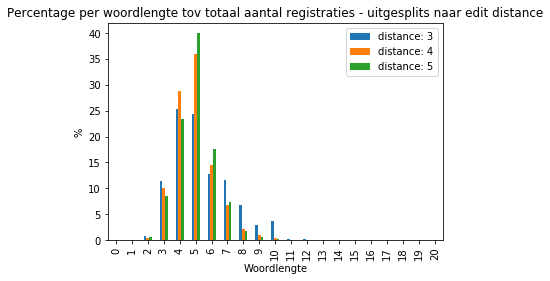

In [109]:
# barplot van het percentage van de count per woordlengte tov het totaal (per edit distance)
df[['3-perc', '4-perc', '5-perc']].plot.bar()
plt.title('Percentage per woordlengte tov totaal aantal registraties - uitgesplits naar edit distance')
plt.xlabel('Woordlengte')
plt.ylabel('%')
plt.legend(['distance: 3', 'distance: 4', 'distance: 5'])
plt.savefig(source_directory + 'percentage_per_woordlengte_per_distance.png', dpi=100, bbox_inches='tight')
plt.show()

In [106]:
df.to_csv(source_directory + 'dist_in_een_woord.csv', sep="|")

In [66]:
# Totaal aantal matches met een afstand van 3 in 1 naam
df[3].sum()

9010.0

In [67]:
# Totaal aantal matches met een afstand van 4 in 1 naam
df[4].sum()

18191.0

In [68]:
# Totaal aantal matches met een afstand van 5 in 1 naam
df[5].sum()

33093.0